In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('lab03.ok')

Assignment: lab03
OK, version v1.14.15



# Lab 3: Building a Tetris AI

This assignment is composed of 10 graded exercises. For each solved exercise, you get the points indicated below. You need to score at least **8 points** (out of 13) **to pass the assignment**.

## Instructions

 - Download a copy of this notebook from [Blackboard](https://esiee.blackboard.com/).
 
 
 - Run `jupyter notebook` on your computer, and open the `.ipynb` file that you just downloaded.


 - Solve the quizzes by filling in the cells with your solutions. 
 
 
 - Check your answer by running the unit test provided at the end of each quiz.
 
 
 - **Submit your work and get it checked before leaving the lab**, otherwise you won't get any credit for it.

## Grading

| Exercise | Topic | Points |
|----------|------|--------|
| [Quiz 1](#Quiz-1) | Warm up | 1 |
| [Quiz 2](#Quiz-2) | Placement | 1 |
| [Quiz 3](#Quiz-3) | Column height | 1 |
| [Quiz 4](#Quiz-4) | Total height | 1 |
| [Quiz 5](#Quiz-5) | Complete lines | 1 |
| [Quiz 6](#Quiz-6) | Holes | 1 |
| [Quiz 7](#Quiz-7) | Bumpiness | 1 |
| [Quiz 8](#Quiz-8) | Score | 1 |
| [Quiz 9](#Quiz-9) | Tetris AI | 2 |
| [Quiz 10](#Quiz-10) | Optimization | 3 |

## Required packages

For this assignment, you need to import (and install if needed) the following packages.
- [**Numpy**](www.numpy.org) - The library for scientific computing in Python.

- [**Joblib**](http://matplotlib.org) - The library for easy simple parallel computing in Python.

- [**PyGame**](https://www.pygame.org) - The library for writing video games in Python.

## Installation

PyGame is not included in the standard Python installation. The simplest way to install PyGame is to open a terminal and run the command

> `pip install pygame`

If this command fails, you can locally install the precompiled binaries as follows.

- Download the file `pygame.zip` that we made available for you on Blackboard.
  
- Unzip the archive, and copy the folder `pygame` into the folder `tetris`.

<!--
- Decompress the Joblib wheel with [7zip](https://www.7-zip.org/), and copy the folder `joblib` in the same folder as this notebook.
-->

---

**Alternative route (if everything else failed)**

- Go to [Pypi](https://pypi.org/) or [this page](https://www.lfd.uci.edu/~gohlke/pythonlibs/#pygame), search for **PyGame**, and download the wheel file (`.whl` extension).

- Select the most recent version of the wheel, according to the python version installed on your computer!

- Unzip the wheel with [7zip](https://www.7-zip.org/).

- Find the folder `pygame`, and copy it into the folder `tetris`.

In [2]:
import numpy as np
import joblib
from tetris.env import TetrisEnv, Tetromino, Board

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Introduction

Tetris is a popular video game created by Alexey Pajitnov in 1985. The game is played on a grid originally composed of 20 rows and 10 columns, where pieces of 7 different shapes fall from the top. The player has to choose where to place each falling piece by moving it horizontally and rotating it. When a row is filled, it is removed and all the cells
above it move one line down. The goal is to remove as many rows as possible. The game is over when there is no space available at the top of the grid for the new piece.

In the following, we consider the variation of the game in which the player knows only the current falling piece. This game constitutes an interesting optimization benchmark, in which the goal is to find a policy that maximizes the number of lines removed in a game. This optimization problem is known to be computationally hard. It contains a huge number of board configurations (about $2^{200} \approx 1.6 \times 10^{60}$), and even in the case that the sequence of pieces is known in advance, finding the optimal strategy is an NP-hard problem.
 
 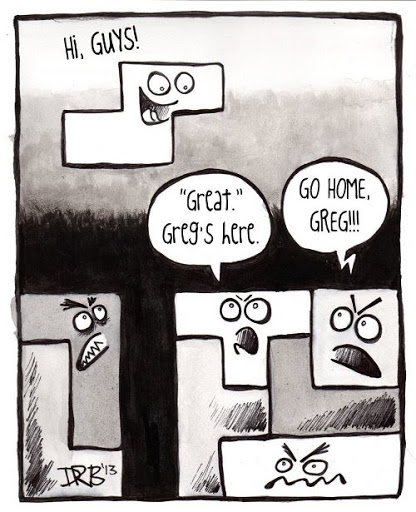

## Tetris environment

The class `TetrisEnv` (provided with the notebook) allows you to create an interactive environment that plays tetris.

In [3]:
env = TetrisEnv()

The main methods of this environment are as follows.

 - **`reset()`** - Reset tetris to its initial state.
 
 - **`render()`** - Visualize the current state of tetris.
 
 - **`step(action)`** - Execute an action and update the state of tetris.

By calling the function `step()`, the tetris environment evolves according to the action specified as input. Actions are coded as integers between 0 and 5, and control the falling tetromino as follows. 
> - **0:** Idle 
> - **1:** Move left 
> - **2:** Move right
> - **3:** Rotate left 
> - **4:** Rotate right
> - **5:** Drop down.

The next cell plays the game for 100 steps, where the arrow keys are used to generate the actions.

**Note:** A window should pop up. Press *alt-tab* if you don't see it.

In [4]:
env.reset()
for _ in range(100):
    env.render()
    action = env.screen.action
    state, reward, done = env.step(action)
env.close()

### Ungraded quiz

Now that you know how to control the environment, it's time to develop your first AI that plays tetris. 

> **Complete the code below by setting the variable `action` to a random integer between `0` and `5` (included).**

> *Hint:* [`np.random.randint`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html#numpy.random.randint)

In [5]:
env.reset()
for _ in range(100):
    env.render()
    action = np.random.randint(5)
    state, reward, done = env.step(action)
env.close()

## State variables

The tetris AI's job is to move or rotate the falling tetromino at each step, so as to drop it into the "best possible" spot. To do this, the tetris AI has access to the current state of the game, defined as

> - **board** - the previously dropped tetrominos, minus the cleared lines;
> - **tetrimino** - the tetromino that is currently falling down. 

The current state of the game is returned by the function `step()` in the variable `state`, which is a tuple `(board, tetromino)`.

In [6]:
board, tetromino = state

print(board)

   o--------------------o
 0 |                    |
 1 |                    |
 2 |                    |
 3 |                    |
 4 |                    |
 5 |                    |
 6 |                    |
 7 |                    |
 8 |                    |
 9 |                    |
10 |                    |
11 |            []      |
12 |        [][][]      |
13 |          []        |
14 |          [][]      |
15 |          []        |
16 |    [][]  []        |
17 |  [][]    []    []  |
18 |[][]      []  [][]  |
19 |[][]      []  []    |
   o--------------------o


### Tetromino

The falling tetromino is an object of the class `Tetromino`, which provides the basic operations:

- `move_right()` - Return a **new** tetromino shifted one step on the right.


- `move_left()` - Return a **new** tetromino shifted one step on the left.


- `move_down()` - Return a **new** tetromino shifted one step down.


- `rotate_right()` - Return a **new** tetromino rotated clock-wise.


- `rotate_left()` - Return a **new** tetromino rotated counter clock-wise.

**NOTE:** The above functions **never** modify the tetromino itself; they always return a **new** tetromino. 

### Board

The board is an object of the class `Board`, which allows you to perform the basic operations:


- `add(tetromino)` - Return a **new** board with the tetromino placed at its location.


- `drop(tetromino)` - Return a **new** tetromino obtained by pushing the input tetromino all the way down on the board. Return `None` if the input tetromino cannot be placed on the board at its initial position.


- `drop(tetromino, column)` - Return a **new** tetromino obtained by moving the input tetromino to the top of the specified column, and then pushing it all the way down on the board. Return `None` if the input tetromino cannot be placed on the board at its initial position.


**NOTE:** The above functions **never** modify the board itself; they always return a **new** board or tetromino. 

### Quiz 1


> **Complete the code below to drop the tetromino as indicated in the figure.**

> *Hints:* 
> - Move and/or rotate the tetrimino with the methods `piece.move_xxx()` and `piece.rotate_xxx()`. 
> - Push the tetromino all the way down on the board with the method `board.drop(piece)`. 
> - Place the tetromino on the board with the command `board.add(piece)`. 

> *Remember:* 
> - The methods invoked on a tetromino or a board **never** modify the object itself; they always return a **new** object. 

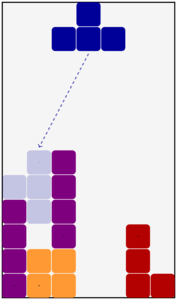

In [7]:
board = Board([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
               [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

piece = Tetromino.create('T', (3,1))

# YOUR CODE HERE
# Step 1: Rotate and move left/right the tetromino to a suitable position.
piece=piece.move_left().move_left()
piece=piece.rotate_left()
# Step 2: Drop the tetromino all the way down on the board.
piece=board.drop(piece)
# Step 3: Add the tetromino to the board.

new_board = board.add(piece)  # Set this variable to the modified board, otherwise the test will fail

print('        BEFORE')
print(board.add(Tetromino.create('T', (3,1))))
print('\n        AFTER')
print(new_board)

        BEFORE
   o--------------o
 0 |      []      |
 1 |    [][][]    |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |    []        |
 7 |    []        |
 8 |[]  []        |
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o

        AFTER
   o--------------o
 0 |              |
 1 |              |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |  [][]        |
 7 |[][][]        |
 8 |[][][]        |
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o


In [8]:
ok.grade("state")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

## Tetromino placement

When the AI plays the game, it is presented with a board and a new tetromino, and tries to make a decision about where to place the tetromino. The latter can be placed on the game board in many ways, with different rotations and translations. Some of these placements are favorable, and others are disadvantageous. In order to decide which placements are good and which are bad, the AI must try every possible placement and choose the one with the best score, according to the scoring system discussed in the next section. As the goal is to clear as many lines as possible, the scoring system must be able to find a suitable placement for the current tetromino, and make sure that subsequent tetrominoes can be placed favorably.

The figure below illustrates the process of iterating through every possible placement of a tetromino. Note that the total number of possible placements depends both on the falling tetromino and the current board. The maximum number of placements is 32. In the following, you are going to implement this process in incremental steps.


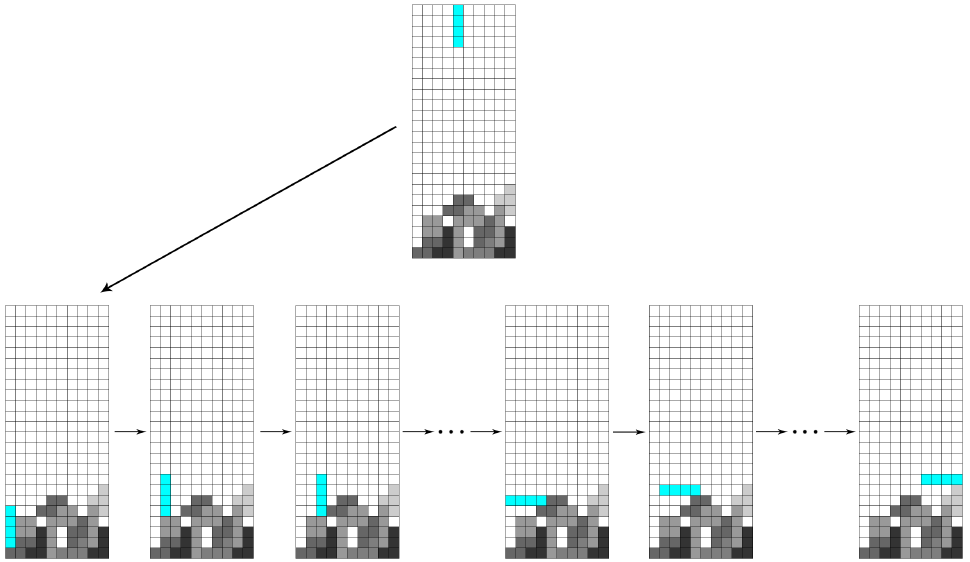

### Quiz 2

> **Implement a function that returns the following outputs.**
>  1. The list of grids associated to every possible way (both *position* and *rotation*) of dropping a tetromino on a board.
>  - The list of dropped tetrominos used to generate each grid in the above list.

In [9]:
def next_moves(board, piece):
    orientations = {'T': 4, 'J': 4, 'L': 4, 'Z': 2, 'S': 2, 'I': 2, 'O': 1}
    grids  = []
    tetros = []
    
    # Try all possible orientations
    for i in range(orientations[piece.name]):
        
        # Rotate the piece
        piece = piece.rotate_right()
        
        # Try all the columns in the board
        for column in range(board.columns()):
            
            # drop the piece on the given column
            landed_piece = board.drop(piece,column)
            
            # skip to the next column if the piece cannot be landed
            if landed_piece is None:
                continue
            
            # add the landed piece to the board
            modified_grid = board.add(landed_piece)
            
            # store for later
            tetros.append(landed_piece)
            grids.append(modified_grid)
            
    return grids, tetros

In [10]:
ok.grade("next_moves")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

## Scoring system

The AI decides the best move by trying out all the possible ways (rotations and positions) of landing the falling tetromino. It computes a score for each possible move, and selects the one with the best score as its next move. As a consequence, the most crucial part of the AI is the scoring system. In order to survive as long as possible, the AI must be able to give a high score to the most favorably moves for the current tetromino. The score for each possible move is computed by assessing the grid the move would result in, based on four features:

- Total height,

- Complete lines,

- Number of holes,

- Bumpiness.

### Quiz 3

> **Implement a function that returns the "height" of each column in a matrix with 0/1 elements.**

> *Hint:* The figure below shows the column heights of a test matrix.

---

- The **height** of a column is the distance from the highest occupied tile to the bottom of the column (see figure below). 


- The height of an empty column is zero.


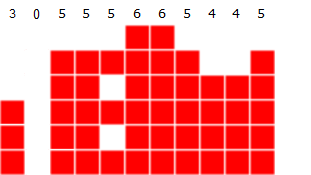

In [11]:
#Première façon que j'ai trouvé pour calculer la hauteur des colonnes
#je l'ai changé par une solution plus simple par la suite

def column_height(grid):
    """
    Arguments:
    grid - Numpy matrix with 0/1 elements
    
    Returns:
    height - A list with the column heights of 'grid'
    """
    height=np.flip(grid.T,axis=1) #on tourne et on renverse la grille pour la suite, c'est plus simple pour la visualisation.
    height=np.where(height==0,height,np.indices((grid.T.shape[1],))+1) # pour chaque ligne, lorsqu'on a un 1,
    #on remplace le 1 par la hauteur à laquelle il est.
    
    #exemple :
#    [[1 2 3 0 0 0]
#     [0 0 0 0 0 0]
#     [1 2 3 4 5 0]
#     [1 2 3 4 5 0]
#     [1 0 3 0 5 0]
#     [1 2 3 4 5 6]
#     [1 2 3 0 0 6]
#     [1 2 3 4 5 0]
#     [1 2 3 4 0 0]
#     [1 2 3 4 0 0]
#     [1 2 3 4 5 0]]

    height=height.max(axis=1)
    
    #Ensuite on a qu'à garder les maximums de ce nouveau tableau qui nous donne la hauteur de la colonne.
    
    return height.astype(int)

# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(30))
print(board)
print()
print('Column height:', column_height(board.grid.T))

          TEST BOARD          
   o----------------------o
 0 |          [][]        |
 1 |    [][][][]  []    []|
 2 |    [][]  []  [][][][]|
 3 |[]  [][][][][][][][][]|
 4 |[]  [][]  [][][][][][]|
 5 |[]  [][][][][][][][][]|
   o----------------------o

Column height: [3 0 5 5 5 6 6 5 4 4 5]


In [12]:
def column_height(grid):
    """
    Arguments:
    grid - Numpy matrix with 0/1 elements
    
    Returns:
    height - A list with the column heights of 'grid'
    """

    height=grid.shape[0]*(1-np.amax(grid,axis=0)==0) - np.argmax(grid,axis=0)
    
    #le premier terme vaut 0 si la ligne est remplie de 0 et la hauteur maximale de la grille sinon
    #ensuite on soustrait à l'argument du premier 1 qui est trouvé pour avoir la hauteur de chaque colonne.
    
    return height.astype(int)

# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(30))
print(board)
print()
print('Column height:', column_height(board.grid.T))

          TEST BOARD          
   o----------------------o
 0 |          [][]        |
 1 |    [][][][]  []    []|
 2 |    [][]  []  [][][][]|
 3 |[]  [][][][][][][][][]|
 4 |[]  [][]  [][][][][][]|
 5 |[]  [][][][][][][][][]|
   o----------------------o

Column height: [3 0 5 5 5 6 6 5 4 4 5]


In [13]:
ok.grade("column_height")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

### Quiz 4

> **Implement a function that returns the "total height" of a board.**

> *Hint:* The figure below shows the total height of a test board.

---

- The **total height** is the sum of the height of each column.


- The Tetris AI wants to minimize this value, because a smaller total height means that more pieces can be dropped into the board before hitting the top and losing the game.

 
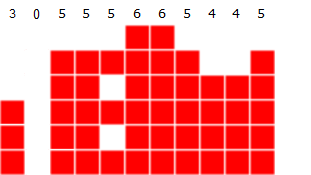
 
$$ \textrm{total height} = 3 + 0 + 5 + 5 + 5 + 6 + 6 + 5 + 4 + 4 + 5 = 48 $$

In [14]:
def total_height(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    total - The total height of the board
    """
    grid = board.grid.T  # <-- USE THIS: a numpy matrix representing the board

    total = column_height(grid).sum()

    return total


# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(30))
print(board)
print()
print('Total height:', total_height(board))

          TEST BOARD          
   o----------------------o
 0 |          [][]        |
 1 |    [][][][]  []    []|
 2 |    [][]  []  [][][][]|
 3 |[]  [][][][][][][][][]|
 4 |[]  [][]  [][][][][][]|
 5 |[]  [][][][][][][][][]|
   o----------------------o

Total height: 48


In [15]:
ok.grade("total_height")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

### Quiz 5

> **Implement a function that returns the number of "complete lines" in a board.**

> *Hint:* The figure below shows the number of complete lines in a test board.

---

- A **complete line** is a row with no holes (see figure below). 


- The AI wants to maximize this value, because clearing lines makes more space for more pieces. 


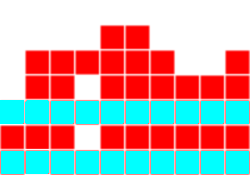

$$ \textrm{complete line} = 2 $$

In [16]:
def complete_lines(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    lines - The number of complete lines in the board
    """
    grid = board.grid.T  # <-- USE THIS: a numpy matrix representing the board

    lines = grid.all(axis=1).sum()

    return lines

# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(28))
print(board)
print()
print('Complete lines:', complete_lines(board))

         TEST BOARD         
   o--------------------o
 0 |        [][]        |
 1 |  [][][][]  []    []|
 2 |  [][]  []  [][][][]|
 3 |[][][][][][][][][][]|
 4 |[][][]  [][][][][][]|
 5 |[][][][][][][][][][]|
   o--------------------o

Complete lines: 2


In [17]:
ok.grade("complete_lines")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

### Quiz 6

> **Implement a function that returns the "number of holes" in a grid.**

> *Hint:* The figure below shows the number of holes in a test board.

---

- A **hole** is an empty tile with at least one block above it in the same column (see figures below).


- The AI wants to minimize this value, because the holes are harder to clear, since all the lines above a hole must be cleared before it can be filled up.
 

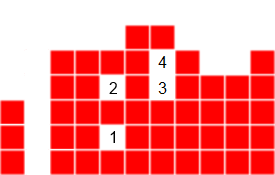

$$ \textrm{holes} = 4 $$

In [18]:
def number_holes(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    holes - The number of holes in the board
    """
    grid  = board.grid.T  # <-- USE THIS: a numpy matrix representing the board
    
    # YOUR CODE HERE
    holes  = (column_height(grid) - np.linalg.norm(grid,ord=1,axis=0).astype(int)).sum()
    #nombre de trous = somme de ( taille totale de la colonne - nombres de carrés remplis )
    
    return holes


# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(30))
print(board)
print()
print('Number of holes:', number_holes(board))

          TEST BOARD          
   o----------------------o
 0 |          [][]        |
 1 |    [][][][]  []    []|
 2 |    [][]  []  [][][][]|
 3 |[]  [][][][][][][][][]|
 4 |[]  [][]  [][][][][][]|
 5 |[]  [][][][][][][][][]|
   o----------------------o

Number of holes: 4


In [19]:
ok.grade("number_holes")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

### Quiz 7

> **Implement a function that returns the "bumpiness" of a board.**

> *Hint:* The figure below shows the bumpiness of a test board.
---

- The **bumpiness** is the sum of the absolute difference in height between all two consecutive columns. 


- The bumpiness measures the variation of its column heights. A big variation indicates the presence of wells, which are undesirable in a grid, because all the rows which the well spans are harder to clear. The AI wants to minimize this value, to ensure that the top of the grid is as monotone as possible.


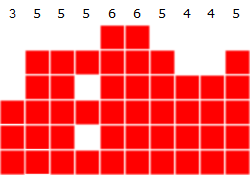

$$ {\rm bumpiness} = |3-5| + |5-5| + \dots + |4-4| + |4-5| = 6$$

In [20]:
def bumpiness(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    bump - The bumpiness of the board
    """
    grid  = board.grid.T  # <-- USE THIS: a numpy matrix representing the board

    # YOUR CODE HERE
    col=column_height(grid)
    bump = np.diff(col)
    bump = np.abs(bump).sum()

    return bump


# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(28))
print(board)
print()
print('Bumpiness:', bumpiness(board))

         TEST BOARD         
   o--------------------o
 0 |        [][]        |
 1 |  [][][][]  []    []|
 2 |  [][]  []  [][][][]|
 3 |[][][][][][][][][][]|
 4 |[][][]  [][][][][][]|
 5 |[][][][][][][][][][]|
   o--------------------o

Bumpiness: 6


In [21]:
ok.grade("bumpiness")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 2, 'failed': 0, 'locked': 0}

### Quiz 8

> **Implement a function that returns the overall score of a board.**

---

After a tetromino is moved to one of the possible placements, the resulting board is scored by taking a linear combination of its four features:

$$ \boxed{{\sf score} = - w_0 \times \textsf{total height} + w_1 \times \textsf{complete lines} - w_2 \times {\sf holes} - w_3 \times {\sf bumpiness}} $$

where $w_0, w_1, w_2, w_3$ are some positive weights.

In [22]:
def compute_score(board, w=[1, 1, 1, 1]):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    bump - The overall score of the board
    """
    score = -w[0]*total_height(board)+w[1]*complete_lines(board)-w[2]*number_holes(board)-w[3]*bumpiness(board)

    return score


# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(28))
print(board)
print()
print('Score:', compute_score(board))

         TEST BOARD         
   o--------------------o
 0 |        [][]        |
 1 |  [][][][]  []    []|
 2 |  [][]  []  [][][][]|
 3 |[][][][][][][][][][]|
 4 |[][][]  [][][][][][]|
 5 |[][][][][][][][][][]|
   o--------------------o

Score: -56


In [23]:
ok.grade("compute_score")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 2, 'failed': 0, 'locked': 0}

## Tetris AI

The Tetris AI algorithm works as follows.

 1. Enumerate the boards resulting from ALL possible placements (shifts and rotations) of the falling tetromino.
 
 - Calculate the score for each board.
 
 - Move the tetromino towards the position with the highest score.
 
One difficulty is that a tetromino **cannot** be instantly moved to the chosen position. At each step, the AI can only provide one of the following actions.

- `0` - Idle

- `1` - Move left

- `2` - Move right 

- `3` - Rotate left

- `4` - Rotate right

- `5` - Drop down

### Quiz 9

> **Implement a function that returns the next action given the current board and the falling tetromino.**

> *Hint:* You will find useful the functions `next_moves()` and `compute_score()` that you have already implemented. 

In [24]:
class TetrisAI:
    def __init__(self):
        self.target = None

    def __call__(self, state, w):
        board, piece = state

        # Find the best way to land the falling tetromino
        if self.target is None:

            # List all the possible ways to land the falling tetromino
            grids, tetros = next_moves(board, piece)

            # Evaluate all the future grids
            scores = []
            for g in grids:
                scores.append(compute_score(g, w))

            # Set 'self.target' to the best landed tetromino
            self.target = tetros[np.argmax(scores)]

        # Action that brings the falling tetromino closer to the best landed tetromino
        action = piece.action_for(self.target)

        # Reset the target after a "drop down"
        if action == 5:
            self.target = None

        return action

In [25]:
ok.grade("TetrisAI")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

### Play tetris with your AI

Let's see the tetris AI in action! With the default weights $w_0=\dots=w_3 = 1$, the AI will probably loose after clearing 20-30 lines. Nonetheless, you can make an unbeatable AI by optimizing those parameters with the cross-entropy method, as you will see in the next section.

The next cell defines a generic function to play tetris with several adjustable parameters.

In [26]:
def play_tetris(params, horizon=1000, repeat=1, render=False):
    
    # Initialization
    params = np.atleast_2d(params)
    batch  = params.shape[0]
    
    # Function to play the game
    def rollout(seed, w):
        policy = TetrisAI()
        tetris = TetrisEnv()
        tetris.seed(42+seed)
        score = 0
        for _ in range(repeat):
            state = tetris.reset()
            for _ in range(horizon):
                action = policy(state, w)
                state, reward, done = tetris.step(action)
                score += reward / repeat
                if render: tetris.render()  
                if done: break
        tetris.close()
        return score
      
    # Play several games in parallel
    n_jobs = 8
    scores = joblib.Parallel(n_jobs)(joblib.delayed(rollout)(i, w) for i, w in enumerate(params))
    
    return np.array(scores).squeeze()

In [27]:
params = [1, 1, 1, 1]
params = [0.5, 0.5, 0.25, 0.1]

scores = play_tetris(params, render=True)

print('Complete lines:', scores)
#params = [1,1,1,1] score 30
#params = [0.5, 0.5, 0.25, 0.1] score 81

Complete lines: 81.0


### Ungraded quiz

> **Try to increase the number of complete lines by manually changing the values of $w_0,w_1,w_2,w_3$.** 

## Optimization of scoring weights

Adjusting the tetris AI scoring weights can be formulated as an optimization problem. The goal is to find the values ${\bf w}=[w_0, w_1, w_2, w_3]$ that allow the tetris AI to maximize the number of complete lines. This can be mathematically written as

$$
\operatorname*{maximize}_{ {\bf w}\in\mathbb{R}^4 } \; J_{\rm lines}( {\bf w} ).
$$

Of course, we don't know the analytical expression of the function $J_{\rm lines}$. We do know however how to evaluate this function on a given vector of parameters: we just need to play tetris using them as scoring weights. Derivative-free methods are particularly handy in this scenario, because they only require us to provide a mean to evaluate $J_{\rm lines}$, which is just the function `play_tetris()` defined above! In the following, we will use a noisy variant of the cross-entropy method to optimize the tetris AI scoring weights. At the time of writing, this approach is considered the state-of-the-art for tetris.

### Quiz 10

> **Implement a function that returns the mean and the standard deviation of elite samples.**

> *Hint:* This exercise is similar to **Quiz 3.1** in **Lab02**, except that here you want to maximize rather than minimize.

In [28]:
def elite_statistics(params, scores, n_elites):

    # Find the indices that would sort the scores
    idx = np.argsort(scores)

    # Select the 'params' rows associated to the 'n_elites' largest scores
    elites = params[idx[-n_elites:]]

    # Compute the mean/std of 'elites' columns
    mean = elites.mean(axis=0)
    std = elites.std(axis=0)

    return mean, std, elites[-1]

In [29]:
ok.grade("elites")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



{'passed': 1, 'failed': 0, 'locked': 0}

### Cross-entropy method

Run the next cell to optimize the weights $w_0,w_1,w_2,w_3$ through the cross-entropy method. 

**Warning:** This will take quite long time (possibly more than 10-15 minutes).

In [30]:
def policy_search(epochs=100, batch=100, elite=0.2, horizon=1000, repeat=1):
    np.random.rand(1)
    
    # Settings
    n_elites    = int(batch * elite)
    extra_std   = 2.0
    extra_decay = epochs * 0.6
    
    # Initalization
    size = 4
    mean = np.zeros(size)
    std  = np.ones(size)
    
    # Best score overall
    best_score = -np.inf
    best_param = None
    
    # Training
    history = []
    for it in range(epochs):

        # Compute the noisy covariance
        extra_cov = max(1.0 - it / extra_decay, 0) * extra_std**2
        cov = np.diag(std**2 + extra_cov)

        # Randomly draw several sets of parameters
        params = np.random.multivariate_normal(mean, cov, batch)

        # Estimate the score for each set of parameters
        scores = play_tetris(params, horizon, repeat)
            
        # Learn from the top-performing sets of parameters
        mean, std, best = elite_statistics(params, scores, n_elites)
        
        # Save the best parameters
        if scores.max() >= best_score:
            best_score = scores.max()
            best_param = best.copy()

        # Track the history
        history.append(scores.mean())
        
        # Print the info
        if (it+1) % 10 == 0:
            print("Epoch {:3d}/{:3d} - Score (mean/best): {:2.3f} / {:2.3f}".format(it+1, epochs, scores.mean(), best_score))
    
    return best_param / best_param.sum()

In [31]:
best_param = policy_search(epochs=50, batch=50, horizon=500, repeat=1)

print('\nBest weights:', np.round(best_param, decimals=10))

# epochs=50, batch=50, horizon=500
# [0.35819922 0.19515535 0.33390404 0.11274138]

# epochs=100, batch=100, horizon=1000
# [0.38569747 0.23920772 0.26717361 0.10792121]

Epoch  10/ 50 - Score (mean/best): 28.580 / 42.000
Epoch  20/ 50 - Score (mean/best): 30.060 / 42.000
Epoch  30/ 50 - Score (mean/best): 33.480 / 42.000
Epoch  40/ 50 - Score (mean/best): 33.260 / 42.000
Epoch  50/ 50 - Score (mean/best): 30.840 / 42.000

Best weights: [0.55569558 0.26857888 0.10375659 0.07196895]


### Play tetris with your AI

Let's see again the tetris AI in action! With the optimized weights $w_0,w_1,w_2,w_3$, the AI should be able to clear around 80 lines. Better scores can be achieved by increasing the values of `epochs`, `batch`, and `horizon`. For example, try with `epochs=100`, `batch=100`, `horizon=1000`.

In [32]:
lines = play_tetris(best_param, render=True, horizon=1000)

print('Complete lines:', lines)

Complete lines: 82.0


You can disable the rendering to play faster, increase the horizon to play longer, and compute the final score as the average number of lines cleared over multiple games.

In [33]:
lines = play_tetris(best_param, horizon=5000, repeat=5)

print('Complete lines:', lines)

Complete lines: 164.99999999999983


The following appears to be a very good scoring function:

$$ \boxed{{\sf score} = - 0.56 \times \textsf{total height} + 0.27 \times \textsf{complete lines} - 0.1 \times {\sf holes} - 0.07 \times {\sf bumpiness}\;} $$

Can you find a better one?

In [34]:
#w = [1, 1, 1, 1]
#w = [0.38569747, 0.23920772, 0.26717361, 0.10792121]
w = [0.56, 0.27, 0.1, 0.07]

lines = play_tetris(w, horizon=5000, repeat=5)

print('Complete lines:', lines)
#w = [1, 1, 1, 1] 13.799999999999985
#w= [0.38569747, 0.23920772, 0.26717361, 0.10792121] 89.60000000000058
#w = [0.56, 0.27, 0.1, 0.07] 164.99

Complete lines: 164.99999999999983


## Acknoledgment

Part of this chapter is based on the [blog post](https://codemyroad.wordpress.com/2013/04/14/tetris-ai-the-near-perfect-player/) written by Yiyuan Lee.

## Suggested readings

- [Approximate Dynamic Programming Finally Performs Well in the Game of Tetris](http://papers.neurips.cc/paper/5190-approximate-dynamic-programming-finally-performs-well-in-the-game-of-tetris)

- [Building Controllers for Tetris](https://hal.archives-ouvertes.fr/inria-00418954/)

# Amélioration du tétris

In [35]:
def landing_height(board, tetro):
    """
    Arguments:
    board - An object of type Board
    tetro - An object of type Tetromino
    
    Returns:
    height - the heiht of the last center's piece
    """

    #on la trouve très facilement à l'aide de tetromino.anchor

    grid = board.grid.T  # <-- USE THIS: a numpy matrix representing the board

    height = grid.shape[0] - tetro.anchor[1]

    return height


# Test board
board = Board([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
               [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

print('        BEFORE')
tetro = Tetromino.create('T', (3, 1))
print(board.add(tetro))

print('\n        AFTER')
tetro = tetro.move_left().move_left()
tetro = tetro.rotate_left()
tetro = board.drop(tetro)
new_board = board.add(tetro)
print(new_board)
print()
print('Landing height:', landing_height(new_board, tetro))

        BEFORE
   o--------------o
 0 |      []      |
 1 |    [][][]    |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |    []        |
 7 |    []        |
 8 |[]  []        |
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o

        AFTER
   o--------------o
 0 |              |
 1 |              |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |  [][]        |
 7 |[][][]        |
 8 |[][][]        |
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o

Landing height: 5


In [36]:
def new_complete_lines(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    lines - The number of complete lines in the board
    indices - the indices of complete lines
    """
    grid = board.grid.T  # <-- USE THIS: a numpy matrix representing the board

    lines = grid.all(axis=1)
    indices = np.where(lines==0,lines,np.indices((grid.T.shape[1],))+1)
    indices=indices.ravel()
    indices=indices[indices!=0]
    indices=indices-1
    
    lines=lines.sum()
    
    return lines, indices

# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(28))
print(board)
print()
print('Complete lines:', new_complete_lines(board))

         TEST BOARD         
   o--------------------o
 0 |        [][]        |
 1 |  [][][][]  []    []|
 2 |  [][]  []  [][][][]|
 3 |[][][][][][][][][][]|
 4 |[][][]  [][][][][][]|
 5 |[][][][][][][][][][]|
   o--------------------o

Complete lines: (2, array([3, 5]))


In [37]:
def erosion(board, tetro):
    """
    Arguments:
    board - An object of type Board
    tetro - An object of type Tetromino
    
    Returns:
    erosion - (number of completed lines) × (number of eliminated cells in the last tetromino)
    """

    grid = board.grid.T  # <-- USE THIS: a numpy matrix representing the board

    #on cherche à trouver l'indice des lignes complété avec le dernier coup.
    #Pour ça, on a modifier la fonction complete_lines.

    count, indices = new_complete_lines(board)

    #tetro.position()
    #[[1 7]
    #[1 8]
    #[1 6]
    #[0 7]]
    #tetro.position() nous donne les positions de toutes les pièces du tetromino.
    #pour avoir le second coefficient, on va créer un meshgrid et regarder si les éléments entre tetro position et indices
    #sont les mêmes. la première colonne sera la position des tetros et la seconde sera les indices des lignes completes.

    nb_tetros = np.meshgrid(tetro.position()[:, 1], indices)
    nb_tetros = np.stack((nb_tetros[0].ravel(), nb_tetros[1].ravel()), axis=1)

    #[[7 7]
    #[8 7]
    # [6 7]
    # [7 7]
    # [7 8]
    # [8 8]
    # [6 8]
    # [7 8]]

    nb_tetros = np.equal(nb_tetros[:, 0], nb_tetros[:, 1])

    #[ True False False  True False  True False False]

    nb_tetros = nb_tetros.sum()
    erosion = count * nb_tetros

    return erosion


# Test board
board = Board([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
               [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]])

print('        BEFORE')
tetro = Tetromino.create('T', (3, 1))
print(board.add(tetro))

print('\n        AFTER')
tetro = tetro.move_left().move_left()
tetro = tetro.rotate_left()
tetro = board.drop(tetro)
new_board = board.add(tetro)
print(new_board)
print()
print('erosion:', erosion(new_board, tetro))

        BEFORE
   o--------------o
 0 |      []      |
 1 |    [][][]    |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |    []        |
 7 |    [][][][][]|
 8 |[]  [][][][][]|
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o

        AFTER
   o--------------o
 0 |              |
 1 |              |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |  [][]        |
 7 |[][][][][][][]|
 8 |[][][][][][][]|
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o

erosion: 6


In [38]:
def rows_transition(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    transition - Nombre de transitions plein/vide ou vide/plein entre les cellules sur chaque ligne
    """
    
    grid  = board.grid.T  # <-- USE THIS: a numpy matrix representing the board
    
    #inspiré du quizz 3.8 du lab01
    padded=np.pad(grid,(1,1),'constant')
    padded[:,0]=1
    padded[:,-1]=1 # remplir de 1 les "murs" à l'extérieur de la grille pour compter
    #la première transition et/ou dernière transition
    
    count=padded[1:-1, :-2] +                   + padded[1:-1, 2:]
    
    #on regarde les cellules à gauche et droite pour savoir si elles contiennent 1.
    #Si au moins une cellule contient un 1, on l'ajoute a notre nouvelle matrice.
    
    count=(((count>0)*(grid==0))*count).astype(int)
    
    #les transitions sont donc les cellules ou on a un 0 et au moins une cellule à 1 à coté multiplié par le nombre de
    #transition lié à une cellule à 0 donné par count (soit 1 soit 2)
    
    transition = count.sum()
    
    return transition


# Test board
board = Board([[0, 0, 0, 1, 1, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 0],
               [1, 1, 1, 1, 1, 0],
               [1, 0, 0, 1, 1, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 0]])
print('TEST BOARD'.center(28))
print(board)
print()
print('Rows transition:', rows_transition(board))

         TEST BOARD         
   o--------------------o
 0 |        [][]        |
 1 |  [][][][]  []    []|
 2 |  [][]  []  [][][][]|
 3 |[][][][][][][][][][]|
 4 |[][][]  [][][][][][]|
 5 |  [][]      [][][]  |
   o--------------------o

Rows transition: 24


In [39]:
def columns_transition(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    transition - Nombre de transitions plein/vide ou vide/plein entre les cellules sur chaque colonne
    """
    
    grid  = board.grid.T  # <-- USE THIS: a numpy matrix representing the board
    
    #inspiré du quizz 3.8 du lab01
    padded=np.pad(grid,(1,1),'constant')
    padded[0,:]=1
    padded[-1,:]=1 #comme avant, on rajoute une ligne de 0 en haut et en bas pour les premières transitions
    count=padded[:-2, 1:-1] \
                            \
          + padded[2: , 1:-1]
    
    #on regarde les cellules en haut et en bas pour savoir si elles
    #contiennent 1, on l'ajoute a notre nouvelle matrice.
    
    count=(((count>0)*(grid==0))*count).astype(int)
    
    transition = count.sum()
    
    return transition


# Test board
board = Board([[0, 0, 0, 1, 1, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 1, 0, 1, 0, 0],
               [1, 1, 1, 1, 1, 0],
               [1, 0, 0, 1, 1, 0],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 1, 1, 1, 1, 0]])
print('TEST BOARD'.center(28))
print(board)
print()
print('Rows transition:', columns_transition(board))

         TEST BOARD         
   o--------------------o
 0 |        [][]        |
 1 |  [][][][]  []    []|
 2 |  [][]  []  [][][][]|
 3 |[][][][][][][][][][]|
 4 |[][][]  [][][][][][]|
 5 |  [][]      [][][]  |
   o--------------------o

Rows transition: 30


In [40]:
def wells(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    wells(puits) - pour tout p puits, somme de (1+2+...+profondeur de p)
    """
    grid  = board.grid
    grid_t = grid.T
    grid=np.flip(grid,axis=1)
    
   #je ne transpose pas la grille par question de réprésentation personnelle
    
    padded=np.pad(grid,(1,1),'constant')
    padded[0,:]=1
    padded[-1,:]=1 #pour pouvoir voir si un puit et tout à gauche ou tout à droite
    
    count=padded[:-2, 1:-1] \
                            \
          + padded[2: , 1:-1]
    
    #à gauche à droite devient en dessous/au dessus si on ne transpose pas
    
    count=((count>1)*(grid==0)).astype(int)
    
    #on veut enlever les puits couverts
    
    count=np.where(count==0,count,np.indices((grid.shape[1],))+1)
    
    surfaces=column_height(grid_t)
    max_high=surfaces.max()
    
    surfaces=surfaces.reshape((grid.shape[0],1))
    surfaces=np.tile(surfaces,(1,grid.shape[1])) #étendre la matrice des tailles pour pouvoir la comparer par la suite
    
    wells=count-surfaces
    wells=np.where(wells>0,1,0) #donne toutes les cases qui sont des puits non couverts
    
    #[[0 0 0 0 0 0]
     #[1 1 0 1 1 0]
    # [0 0 0 0 0 0]
    # [0 0 0 0 0 0]
    # [0 0 0 1 1 0]
    # [0 0 0 0 0 0]
    # [0 0 0 0 0 0]
    # [0 0 0 0 0 0]
    # [0 0 0 1 0 0]
    # [0 0 0 0 0 0]
    # [0 0 1 1 1 1]]
    
    cumsum=np.cumsum(wells,axis=1)
    wells=((wells==1)*(cumsum>0))*cumsum
    
    #[[0 0 0 0 0 0]
     #[1 2 0 3 4 0]
    # [0 0 0 0 0 0]
    # [0 0 0 0 0 0]
    # [0 0 0 1 2 0]
    # [0 0 0 0 0 0]
    # [0 0 0 0 0 0]
    # [0 0 0 0 0 0]
    # [0 0 0 1 0 0]
    # [0 0 0 0 0 0]
     #[0 0 1 2 3 4]]

    wells=wells.sum().astype(int)
    
    return wells

# Test board
board = Board([[0, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 1, 1, 0, 1, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 0, 1, 0, 1],
               [1, 1, 1, 1, 1, 1],
               [1, 0, 0, 0, 0, 1],
               [0, 0, 1, 1, 1, 1],
               [0, 0, 0, 1, 1, 1],
               [1, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 1, 1]])
print('TEST BOARD'.center(30))
print(board)
print()
print('wells:', wells(board))

          TEST BOARD          
   o----------------------o
 0 |          [][]    []  |
 1 |[]  [][]  []      []  |
 2 |[]  [][]  []  []  []  |
 3 |[]    [][][]  [][][]  |
 4 |[]  [][]  []  [][][][]|
 5 |[]  [][][][][][][][][]|
   o----------------------o

wells: 24


In [41]:
def holes_depth(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    holes_depth - profondeur des trous, c’est la somme du nombre de cellules pleines au-dessus de chaque trou
    """
    
    grid  = board.grid
    grid_t = grid.T
    grid=np.flip(grid,axis=1)
    
    padded=np.pad(grid,(1,1),'constant')
    count=padded[1:-1, :-2] #bloc du dessous qui devient le bloc de gauche si la matrice n'est pas transposée
    count=((count>0)*(grid==0)).astype(int) #trouve toutes les "bases" des trous
    count=np.where(count==0,count,np.indices((grid.shape[1],))+1)
    
    #retirer les cubes qui ne sont pas des trous mais qui sont la fin d'une colonne
    
    surfaces=column_height(grid_t)
    
    max_high=surfaces.max()
    
    surfaces=surfaces.reshape((grid.shape[0],1))
    surfaces=np.tile(surfaces,(1,grid.shape[1])) #étendre la matrice des tailles pour pouvoir la comparer par la suite
    
    count=np.where(count>surfaces,0,count) #on a trouvé les bases des trous.
    count=count[count>0]
    
    holes_depth= (max_high - count).sum()
    
    return holes_depth
    
# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 1, 1, 1, 0, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 0, 1, 0, 1],
               [1, 0, 1, 1, 0, 1],
               [1, 0, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 1, 0, 0, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(30))
print(board)
print()
print('Holes Depth:', holes_depth(board))

          TEST BOARD          
   o----------------------o
 0 |          [][][]      |
 1 |    [][]      []    []|
 2 |    [][]  [][][]  [][]|
 3 |[]  [][][][][][][]  []|
 4 |[]    []    [][][]  []|
 5 |[]  [][][][][][][][][]|
   o----------------------o

Holes Depth: 18


In [42]:
def hole_in_rows(board):
    """
    Arguments:
    board - An object of type Board
    
    Returns:
    hole_in_rows - compte le nombre de lignes ayant au moins un trou (deux trous sur la même ligne comptent pour un seul)
    """
    
    grid  = board.grid
    grid_t=grid.T
    grid = np.flip(grid,axis=1)
    
    #on va remplir les 0 qui ne sont pas des trous et ensuite regarder les lignes qui ne sont pas composées que de 1
    
    surfaces=column_height(grid_t)    
    surfaces=surfaces.reshape((grid.shape[0],1))
    surfaces=np.tile(surfaces,(1,grid.shape[1])) #étendre la matrice des tailles pour pouvoir la comparer par la suite
    
    finir_mur=np.where(grid==0,np.indices((grid.shape[1],))+1,grid)
    finir_mur=np.where(finir_mur>=surfaces,1,0)
    grid_fill=grid+finir_mur
    
    #[[1 1 1 1 1 1]
    # [1 1 1 1 1 1]
    # [1 0 1 1 1 1]
    # [1 1 1 1 1 1]
    # [1 0 1 1 1 1]
    # [1 0 1 1 0 1]
    # [1 1 1 1 0 1]
    # [1 1 1 1 1 1]
    # [1 1 1 1 1 1]
    # [1 0 0 1 1 1]
    # [1 1 1 1 1 1]]
    #la grille avec les 0 remplacées par des 1 quand ce ne sont pas des trous
    
    hole_in_rows= np.logical_not(np.all(grid_fill,axis=0)).sum()
    
    return hole_in_rows
    
# Test board
board = Board([[0, 0, 0, 1, 1, 1],
               [0, 0, 0, 0, 0, 0],
               [0, 1, 1, 1, 0, 1],
               [0, 1, 1, 1, 1, 1],
               [0, 0, 0, 1, 0, 1],
               [1, 0, 1, 1, 0, 1],
               [1, 0, 1, 1, 1, 1],
               [1, 1, 1, 1, 1, 1],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 1, 0, 0, 1],
               [0, 1, 1, 1, 1, 1]])
print('TEST BOARD'.center(30))
print(board)
print()
print('Rows with holes:', hole_in_rows(board))

          TEST BOARD          
   o----------------------o
 0 |          [][][]      |
 1 |    [][]      []    []|
 2 |    [][]  [][][]  [][]|
 3 |[]  [][][][][][][]  []|
 4 |[]    []    [][][]  []|
 5 |[]  [][][][][][][][][]|
   o----------------------o

Rows with holes: 3


# Nouveau score

In [43]:
def compute_new_score(board, tetro, w=[1, 1, 1, 1, 1, 1, 1, 1]):
    """
    Arguments:
    board - An object of type Board
    tetro - An object of type Tetromino
    
    Returns:
    score - The overall score of the board and the tetromino
    """
    score = (-w[0] * landing_height(board, tetro) +
             w[1] * erosion(board, tetro) - w[2] * rows_transition(board) -
             w[3] * columns_transition(board) - w[4] * number_holes(board) -
             w[5] * wells(board) - w[6] * holes_depth(board) -
             w[7] * hole_in_rows(board))
    return score


# Test board
board = Board([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
               [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]])

print('        BEFORE')
tetro = Tetromino.create('T', (3, 1))
print(board.add(tetro))

print('\n        AFTER')
tetro = tetro.move_left().move_left()
tetro = tetro.rotate_left()
tetro = board.drop(tetro)
new_board = board.add(tetro)
print(new_board)
print()
print('score:', compute_new_score(new_board, tetro))

        BEFORE
   o--------------o
 0 |      []      |
 1 |    [][][]    |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |    []        |
 7 |    [][][][][]|
 8 |[]  [][][][][]|
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o

        AFTER
   o--------------o
 0 |              |
 1 |              |
 2 |              |
 3 |              |
 4 |              |
 5 |              |
 6 |  [][]        |
 7 |[][][][][][][]|
 8 |[][][][][][][]|
 9 |[]  []    []  |
10 |[][][]    []  |
11 |[][][]    [][]|
   o--------------o

score: -69


# Tetris AI

In [44]:
class TetrisAI_better:
    def __init__(self):
        self.target = None

    def __call__(self, state, w):
        board, piece = state

        # Find the best way to land the falling tetromino
        if self.target is None:

            # List all the possible ways to land the falling tetromino
            grids, tetros = next_moves(board, piece)

            # Evaluate all the future grids
            scores = []
            for i in range(len(grids)):
                scores.append(compute_new_score(grids[i], tetros[i], w))

            # Set 'self.target' to the best landed tetromino
            self.target = tetros[np.argmax(scores)]

        # Action that brings the falling tetromino closer to the best landed tetromino
        action = piece.action_for(self.target)

        # Reset the target after a "drop down"
        if action == 5:
            self.target = None

        return action

In [45]:
def play_tetris_better(params, horizon=1000, repeat=1, render=False):
    
    # Initialization
    params = np.atleast_2d(params)
    batch  = params.shape[0]
    
    # Function to play the game
    def rollout(seed, w):
        policy = TetrisAI_better()
        tetris = TetrisEnv()
        tetris.seed(42+seed)
        score = 0
        for _ in range(repeat):
            state = tetris.reset()
            for _ in range(horizon):
                action = policy(state, w)
                state, reward, done = tetris.step(action)
                score += reward / repeat
                if render: tetris.render()  
                if done: break
        tetris.close()
        return score
      
    # Play several games in parallel
    n_jobs = 8
    scores = joblib.Parallel(n_jobs)(joblib.delayed(rollout)(i, w) for i, w in enumerate(params))
    
    return np.array(scores).squeeze()

In [46]:
#params=[1,1,1,1,1,1,1,1]
params = [12.63, 6.6, 9.22, 19.77, 13.08, 10.49, 1.61, 24.04] 
#paramètres optimaux trouvés par Christophe Thiery et Bruno Scherrer

scores = play_tetris_better(params, render=True)

print('Complete lines:', scores)

    #ANCIENNE FONCTION
#params = [1,1,1,1] score 30
#params = [0.5, 0.5, 0.25, 0.1] score 81

    #NOUVELLE FONCTION
#params=[1,1,1,1,1,1,1,1] score 74, c'est beaucoup mieux qu'avant pour des paramètres non otpimisés !
#params = [12.63, 6.6, 9.22, 19.77, 13.08, 10.49, 1.61, 24.04] score 81

Complete lines: 81.0


# Trouver les meilleurs paramètres

In [47]:
def new_policy_search(epochs=100,
                      batch=100,
                      elite=0.2,
                      horizon=1000,
                      repeat=1):
    np.random.rand(1)

    # Settings
    n_elites = int(batch * elite)
    extra_std = 2.0
    extra_decay = epochs * 0.6

    # Initalization
    size = 8  #on change size car on a désormais 8 paramètres au total
    mean = np.zeros(size)
    std = np.ones(size)

    # Best score overall
    best_score = -np.inf
    best_param = None

    # Training
    history = []
    for it in range(epochs):

        # Compute the noisy covariance
        extra_cov = max(1.0 - it / extra_decay, 0) * extra_std**2
        cov = np.diag(std**2 + extra_cov)

        # Randomly draw several sets of parameters
        params = np.random.multivariate_normal(mean, cov, batch)

        # Estimate the score for each set of parameters
        scores = play_tetris_better(params, horizon, repeat)

        # Learn from the top-performing sets of parameters
        mean, std, best = elite_statistics(params, scores, n_elites)

        # Save the best parameters
        if scores.max() >= best_score:
            best_score = scores.max()
            best_param = best.copy()

        # Track the history
        history.append(scores.mean())

        # Print the info
        if (it + 1) % 10 == 0:
            print("Epoch {:3d}/{:3d} - Score (mean/best): {:2.3f} / {:2.3f}".
                  format(it + 1, epochs, scores.mean(), best_score))

    return best_param / best_param.sum()

# Recherche de paramètres

In [48]:
best_param = new_policy_search(epochs=50, batch=50, horizon=500, repeat=1)

print('\nBest weights:', np.round(best_param, decimals=10))

#epochs=50, batch=50, horizon=500
#[0.15065747 0.05217539 0.04351452 0.32808291 0.19713935 0.12109451 0.02630738 0.08102847]

Epoch  10/ 50 - Score (mean/best): 37.000 / 42.000
Epoch  20/ 50 - Score (mean/best): 38.740 / 43.000
Epoch  30/ 50 - Score (mean/best): 38.740 / 43.000
Epoch  40/ 50 - Score (mean/best): 39.980 / 43.000
Epoch  50/ 50 - Score (mean/best): 39.360 / 43.000

Best weights: [ 0.10685338  0.19221359  0.02807221  0.21584662  0.10965716  0.12902587
 -0.02400682  0.24233799]


# Regarder le résultat

In [49]:
#w = [12.63, 6.6, 9.22, 19.77, 13.08, 10.49, 1.61, 24.04] #paramètres optimaux trouvés par Christophe Thiery et Bruno Scherrer
w = [0.15065747, 0.05217539, 0.04351452, 0.32808291, 0.19713935, 0.12109451, 0.02630738, 0.08102847]

lines = play_tetris_better(w, horizon=5000, repeat=5)

print('Complete lines:', lines)

    #ANCIEN SCORES
#w = [1, 1, 1, 1] 13.799999999999985
#w= [0.38569747, 0.23920772, 0.26717361, 0.10792121] 89.60000000000058
#w = [0.56, 0.27, 0.1, 0.07] 164.99

    #NOUVEAU SCORE
#w = [1, 1, 1, 1, 1, 1, 1, 1] 74.80000000000042
#w = [0.15065747, 0.05217539, 0.04351452, 0.32808291, 0.19713935, 0.12109451, 0.02630738, 0.08102847] 422.9999999999893
#w = [12.63, 6.6, 9.22, 19.77, 13.08, 10.49, 1.61, 24.04] 424.79999999998734

#on explose le score précédémment obtenu avec les paramètres optimaux :
#Nous avons réussi !

Complete lines: 422.9999999999893


In [50]:
def new_policy_search_history(epochs=100,
                              batch=100,
                              elite=0.2,
                              horizon=1000,
                              repeat=1):
    np.random.rand(1)

    # Settings
    n_elites = int(batch * elite)
    extra_std = 2.0
    extra_decay = epochs * 0.6

    # Initalization
    size = 8  # on change size car on a désormais 8 paramètres au total
    mean = np.zeros(size)
    std = np.ones(size)

    # Best score overall
    best_score = -np.inf
    best_param = None

    # Training
    history = []
    for it in range(epochs):

        # Compute the noisy covariance
        extra_cov = max(1.0 - it / extra_decay, 0) * extra_std**2
        cov = np.diag(std**2 + extra_cov)

        # Randomly draw several sets of parameters
        params = np.random.multivariate_normal(mean, cov, batch)

        # Estimate the score for each set of parameters
        scores = play_tetris_better(params, horizon, repeat)

        # Learn from the top-performing sets of parameters
        mean, std, best = elite_statistics(params, scores, n_elites)

        # Save the best parameters
        if scores.max() >= best_score:
            best_score = scores.max()
            best_param = best.copy()

        # Track the history
        history.append(scores.mean())

        # Print the info
        print("Epoch {:3d}/{:3d} - Score (mean/best): {:2.3f} / {:2.3f}".format(
            it + 1, epochs, scores.mean(), best_score))

    return best_param / best_param.sum(), history

In [51]:
def policy_search_history(epochs=100,
                              batch=100,
                              elite=0.2,
                              horizon=1000,
                              repeat=1):
    np.random.rand(1)

    # Settings
    n_elites = int(batch * elite)
    extra_std = 2.0
    extra_decay = epochs * 0.6

    # Initalization
    size = 4  # on change size car on a désormais 8 paramètres au total
    mean = np.zeros(size)
    std = np.ones(size)

    # Best score overall
    best_score = -np.inf
    best_param = None

    # Training
    history = []
    for it in range(epochs):

        # Compute the noisy covariance
        extra_cov = max(1.0 - it / extra_decay, 0) * extra_std**2
        cov = np.diag(std**2 + extra_cov)

        # Randomly draw several sets of parameters
        params = np.random.multivariate_normal(mean, cov, batch)

        # Estimate the score for each set of parameters
        scores = play_tetris(params, horizon, repeat)

        # Learn from the top-performing sets of parameters
        mean, std, best = elite_statistics(params, scores, n_elites)

        # Save the best parameters
        if scores.max() >= best_score:
            best_score = scores.max()
            best_param = best.copy()

        # Track the history
        history.append(scores.mean())

        # Print the info
        print("Epoch {:3d}/{:3d} - Score (mean/best): {:2.3f} / {:2.3f}".format(
            it + 1, epochs, scores.mean(), best_score))

    return best_param / best_param.sum(), history

In [54]:
%matplotlib inline

def comparaison_plot(iterations, batch, horizon, repeat, elite=0.2):
    import matplotlib.pyplot as plt

    x1 = np.arange(1, iterations+1)

    print("------------CHERCHER LES ANCIENS PARAMETRES------------")
    print()
    _, best_means = policy_search_history(epochs=iterations,
                                          batch=batch,
                                          horizon=horizon,
                                          elite=elite,
                                          repeat=repeat)

    print()
    print("------------CHERCHER LES NOUVEAUX PARAMETRES------------")
    print()
    _, best_new_means = new_policy_search_history(epochs=iterations,
                                                  batch=batch,
                                                  horizon=horizon,
                                                  elite=elite,
                                                  repeat=repeat)

    plt.plot(x1, best_means, '--b', x1, best_new_means, '-r')
    plt.ylabel('score moyen')
    plt.xlabel('itérations')
    plt.legend(('ancienne IA', 'nouvelle IA'))

------------CHERCHER LES ANCIENS PARAMETRES------------

Epoch   1/ 10 - Score (mean/best): 3.530 / 78.000
Epoch   2/ 10 - Score (mean/best): 14.230 / 81.000
Epoch   3/ 10 - Score (mean/best): 26.170 / 83.000
Epoch   4/ 10 - Score (mean/best): 36.220 / 84.000
Epoch   5/ 10 - Score (mean/best): 43.990 / 84.000
Epoch   6/ 10 - Score (mean/best): 48.260 / 84.000
Epoch   7/ 10 - Score (mean/best): 49.960 / 84.000
Epoch   8/ 10 - Score (mean/best): 54.450 / 84.000
Epoch   9/ 10 - Score (mean/best): 52.840 / 85.000
Epoch  10/ 10 - Score (mean/best): 55.210 / 85.000

------------CHERCHER LES NOUVEAUX PARAMETRES------------

Epoch   1/ 10 - Score (mean/best): 1.310 / 85.000
Epoch   2/ 10 - Score (mean/best): 4.000 / 85.000
Epoch   3/ 10 - Score (mean/best): 16.150 / 85.000
Epoch   4/ 10 - Score (mean/best): 39.210 / 85.000
Epoch   5/ 10 - Score (mean/best): 60.250 / 85.000
Epoch   6/ 10 - Score (mean/best): 66.630 / 85.000
Epoch   7/ 10 - Score (mean/best): 76.690 / 85.000
Epoch   8/ 10 - Scor

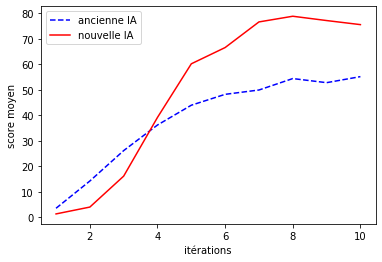

In [55]:
comparaison_plot(iterations=10, batch=100, elite=0.2, horizon=1000, repeat=1)